# 인공지능과 기계학습 13주차 과제

신용카드 고객 데이터에 대해 클러스터링 기반 고객 세분화

### 과제 내용
- 데이터 로드 및 전처리
- EDA 및 로그 정규화
- PCA 기반 차원 축소
- Elbow 및 Silhouette 기반 최적 k 탐색
- KMeans 클러스터링 및 시각화


## 1. 데이터 준비

In [1]:
# 데이터 준비
import pandas as pd
df = pd.read_csv('/Users/dankim/AIML/cardusage.csv')
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


## 2. 데이터 탐색 및 전처리

In [2]:
# 데이터 탐색 및 전처리
print('행, 열:', df.shape)
print('\n결측치 :\n', df.isnull().sum())

# 고객 식별자 제거
df.drop(columns=['CUST_ID'], inplace=True)

# 결측치는 중앙값으로 대체
df['MINIMUM_PAYMENTS'] = df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].median())
df['CREDIT_LIMIT'] = df['CREDIT_LIMIT'].fillna(df['CREDIT_LIMIT'].median())

print('\n결측치 처리 후 남은 결측치:', df.isnull().sum().sum())

행, 열: (8950, 18)

결측치 :
 CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

결측치 처리 후 남은 결측치: 0


## 3. 탐색적 데이터 분석(EDA)

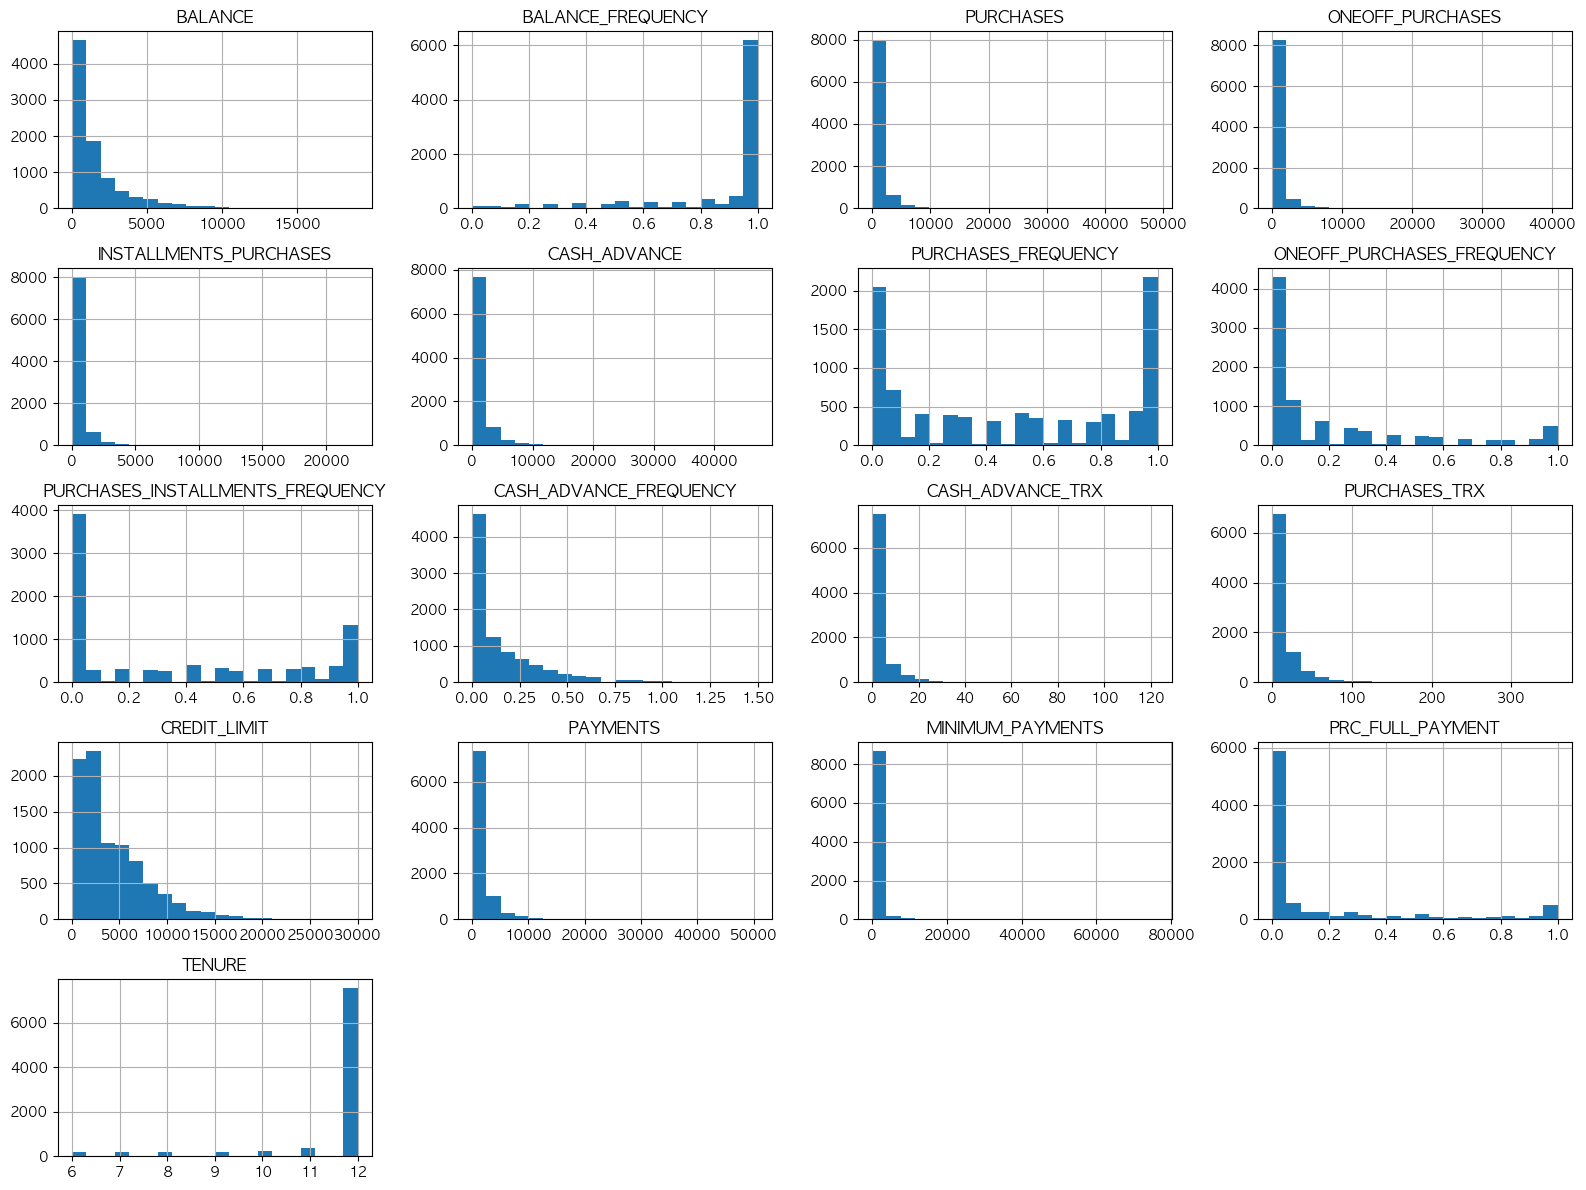

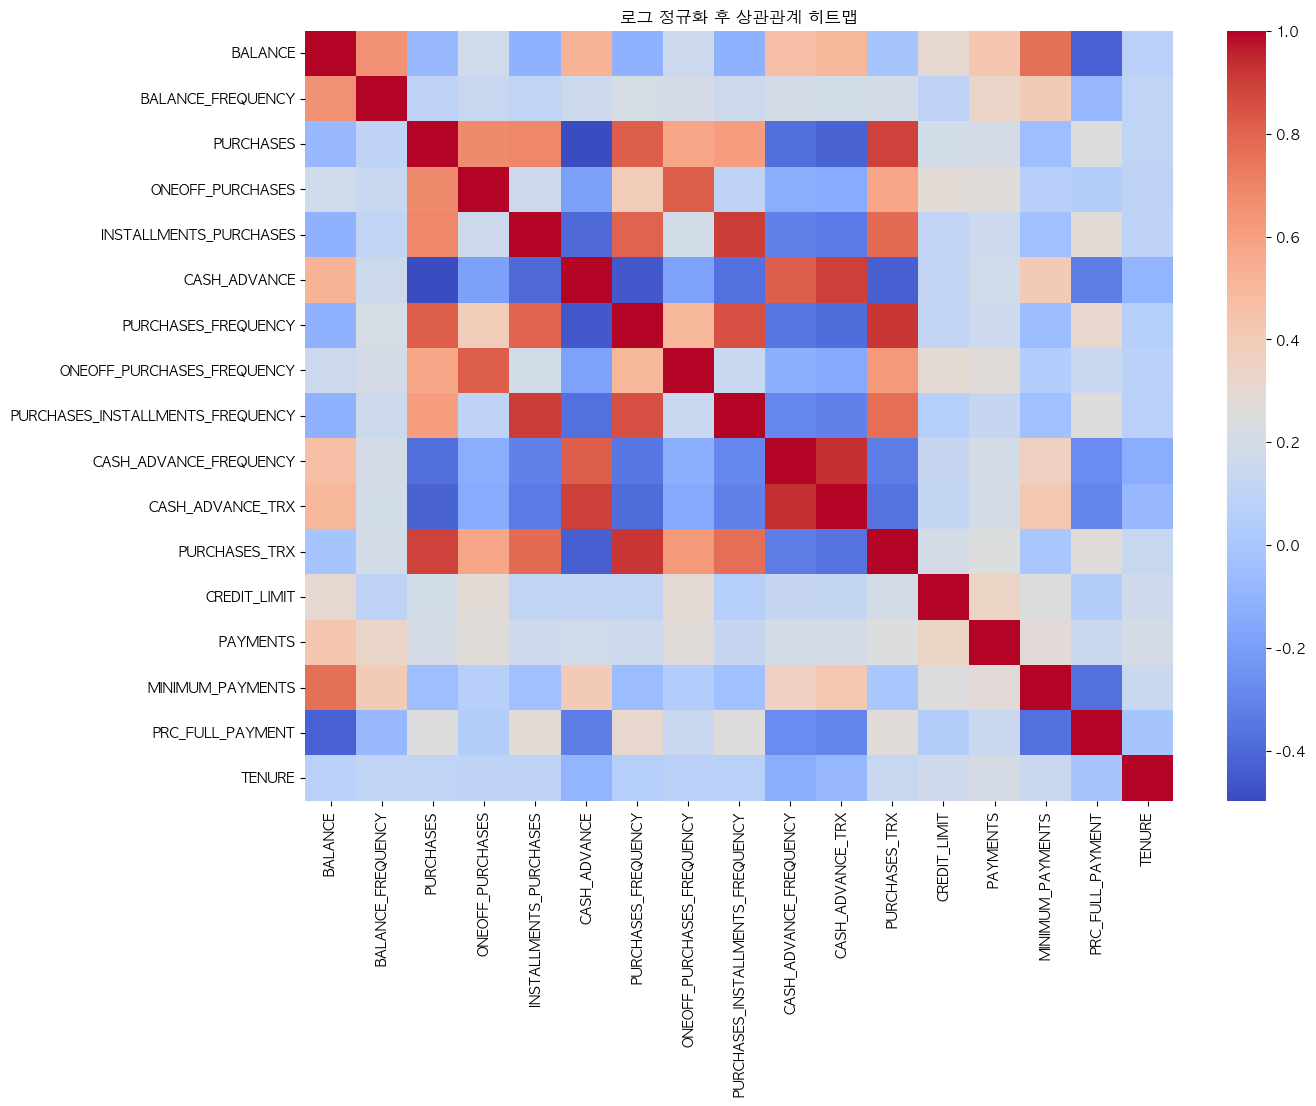

상관관계 0.85 이상 변수 쌍 (일부):
[('PURCHASES', 'PURCHASES_TRX', 0.8889879708258394), ('INSTALLMENTS_PURCHASES', 'PURCHASES_INSTALLMENTS_FREQUENCY', 0.9054428977055484), ('CASH_ADVANCE', 'CASH_ADVANCE_TRX', 0.8983979062246528), ('PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 0.8569763613268183), ('PURCHASES_FREQUENCY', 'PURCHASES_TRX', 0.9218596005225519)]


In [3]:
# 3. 탐색적 데이터 분석 (EDA) 및 로그 정규화
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'

# 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 데이터 특성 파악 - 특징별 분포(히스토그램)
df.hist(bins=20, figsize=(16, 12))
plt.tight_layout()
plt.show()

# 로그 정규화
df_log = np.log1p(df)

# 상관관계 히트맵
plt.figure(figsize=(14, 10))
sns.heatmap(df_log.corr(), cmap='coolwarm')
plt.title('로그 정규화 후 상관관계 히트맵')
plt.show()

# 상관 높은 변수 쌍 확인
corr = df_log.corr().abs()
high_corr_pairs = [(i, j, corr.loc[i, j])
                   for i in corr.columns for j in corr.columns 
                   if i != j and corr.loc[i, j] > 0.85]
print('상관관계 0.85 이상 변수 쌍 (일부):')
print(high_corr_pairs[:5])

## 4. 차원 축소

In [4]:
# 차원 축소 (PCA 95%)
# PCA를 사용해 원본 변수들을 몇 개의 주성분으로 압축
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled = scaler.fit_transform(df_log)

pca = PCA(n_components=0.95)
pca_data = pca.fit_transform(scaled)
print('선택된 주성분 수:', pca.n_components_)

선택된 주성분 수: 10


## 5. 최적 클러스터 수 탐색

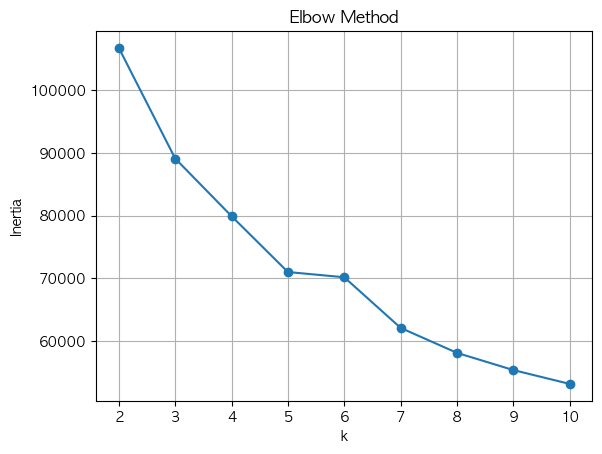

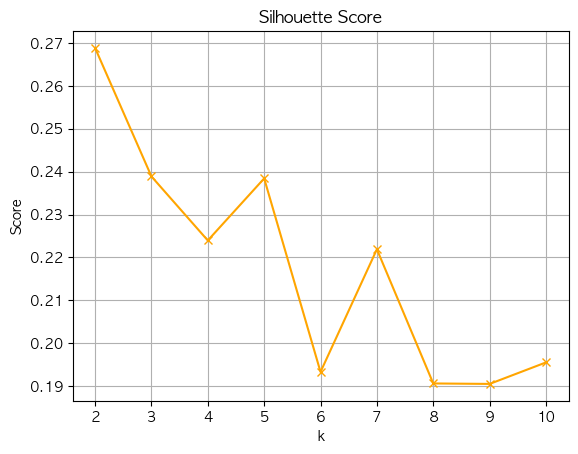

Elbow 기준 후보 k: 4
Silhouette 기준 후보 k: 2
최종 결정한 k (두 기법 종합): 4


In [5]:
# 최적 클러스터 수 탐색
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertias = []
sil_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_data)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(pca_data, kmeans.labels_))

# Elbow 그래프
plt.plot(K, inertias, marker='o')
plt.title('Elbow Method')  # Elbow 기법
plt.xlabel('k'); plt.ylabel('Inertia')
plt.grid(True)
plt.show()

# Silhouette Score 그래프
plt.plot(K, sil_scores, marker='x', color='orange')
plt.title('Silhouette Score')  # Silhouette 점수
plt.xlabel('k'); plt.ylabel('Score')
plt.grid(True)
plt.show()

# 각 기법 결과
elbow_k = 4  # 4부터 기울기가 확 꺾임
silhouette_k = K[np.argmax(sil_scores)]  # Silhouette 기준 최적 k

# 종합 결정
if abs(elbow_k - silhouette_k) <= 1:
    final_k = silhouette_k
else:
    final_k = elbow_k 

print(f'Elbow 기준 후보 k: {elbow_k}')
print(f'Silhouette 기준 후보 k: {silhouette_k}')
print(f'최종 결정한 k (두 기법 종합): {final_k}')

## 6. K-Means 클러스터링 수행

In [6]:
# K-Means 클러스터링 수행
kmeans_final = KMeans(n_clusters=final_k, random_state=42)
labels = kmeans_final.fit_predict(pca_data)

df_log['Cluster'] = labels
cluster_summary = df_log.groupby('Cluster').mean()
cluster_summary.round(2)

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
Cluster,,,,,,,,,,,,,,,,,
0,7.71,0.68,6.70,4.83,4.76,7.27,0.51,0.23,0.38,0.28,1.96,2.73,8.35,7.37,6.83,0.03,2.51
1,4.06,0.52,5.51,1.92,4.13,0.37,0.40,0.05,0.34,0.01,0.06,1.92,7.78,5.70,5.03,0.20,2.51
2,6.57,0.68,7.37,6.30,5.11,0.52,0.59,0.39,0.42,0.01,0.08,3.20,8.41,7.31,6.00,0.18,2.55
3,7.16,0.64,0.97,0.86,0.11,6.74,0.02,0.02,0.00,0.23,1.64,0.20,8.00,6.56,6.27,0.03,2.51


## 7. 클러스터 특성 시각화 및 해석

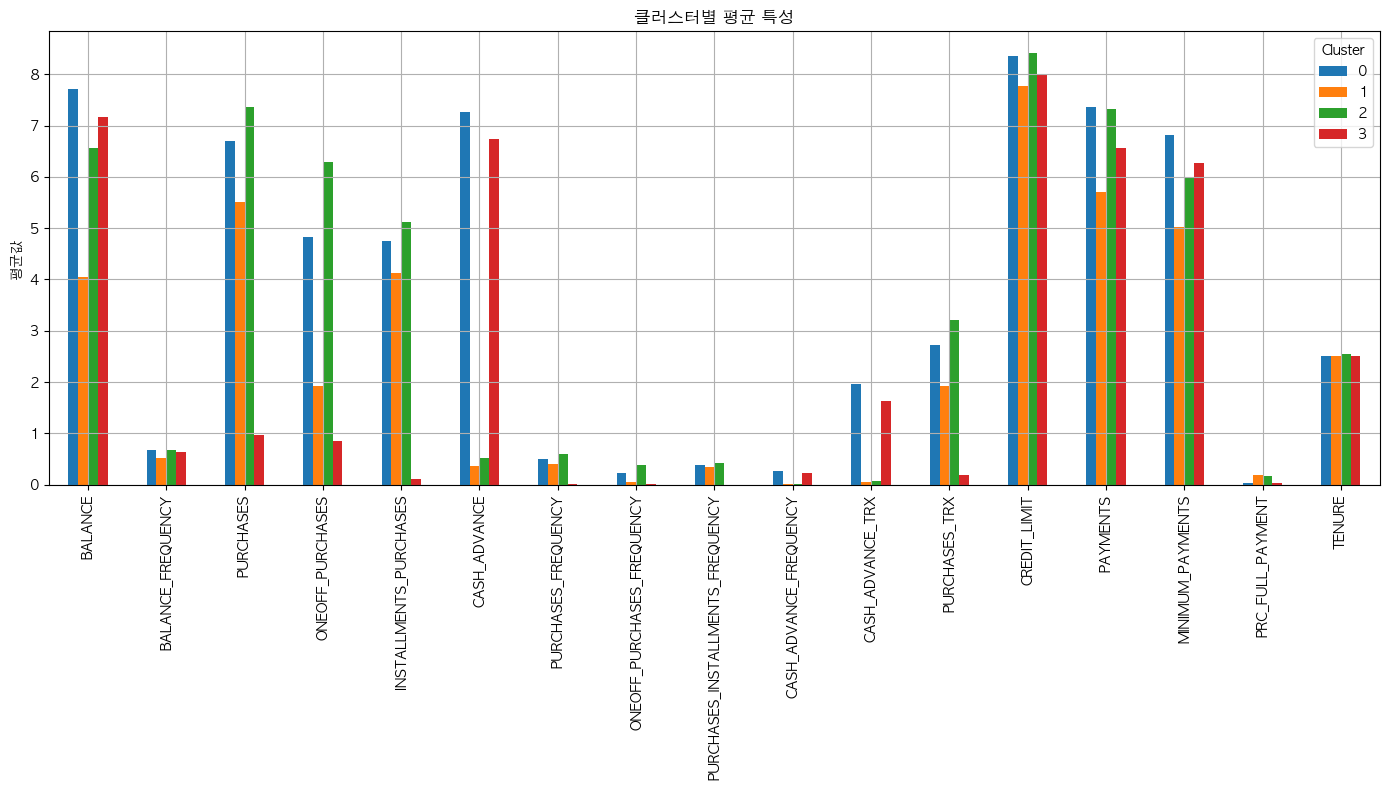

In [7]:
# 7. 클러스터 특성 시각화
cluster_summary.T.plot(kind='bar', figsize=(14, 8))
plt.title('클러스터별 평균 특성')
plt.ylabel('평균값')
plt.grid(True)
plt.tight_layout()
plt.show()

### 클러스터별 고객 특성 인사이트

- **Cluster 0**  
  : 전반적으로 `BALANCE`, `CASH_ADVANCE`, `CREDIT_LIMIT`에 높은 특성을 보이고 있으므로, 현금서비스 이용 및 거래 비율이 높고 잔액이 많으며 한도도 큰 VIP 고객군으로 보임

- **Cluster 1**  
  : `PURCHASES`, `ONEOFF_PURCHASES`, `PURCHASES_TRX`가 매우 낮고, `MINIMUM_PAYMENTS`도 낮은 편으로, 활동이 거의 없는 고객군으로 보임

- **Cluster 2**  
  : `INSTALLMENTS_PURCHASES`, `PURCHASES_INSTALLMENTS_FREQUENCY`가 높으므로, 할부 구매를 많이 하는 고객군으로 보임

- **Cluster 3**  
  : `PRC_FULL_PAYMENT` 비율이 비교적 높고 `MINIMUM_PAYMENTS`도 낮지 않아서, 잔액을 전액 상환하는 고객군으로 보임

